In [17]:

import numpy as np

# Load npz
data = np.load("../data/moon_data.npz")

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

print(f"Training X shape: {X_train.shape}, y shape: {y_train.shape}")
print(f"Validation X shape: {X_val.shape}, y shape: {y_val.shape}")
print(f"Testing X shape: {X_test.shape}, y shape: {y_test.shape}")

Training X shape: (180, 2), y shape: (180,)
Validation X shape: (60, 2), y shape: (60,)
Testing X shape: (60, 2), y shape: (60,)


In [18]:
# Load all depths and find the best model (lowest loss) for each depth
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

import pickle
import numpy as np

results_dir = '../result_tqfm_moon'

# Define depths to analyze
depths = [1, 2, 3, 4, 5, 6, 7, 8 ,9 ,10]
best_models = {}

for depth in depths:
    # Filter TQFM pickle files for this depth
    tqfm_files = [f for f in os.listdir(results_dir) if f.endswith('.pkl') and f'depth{depth}_' in f]
    
    if not tqfm_files:
        print(f"No files found for depth {depth}")
        continue
    
    # Load all models for this depth and find best by loss
    models = []
    for tqfm_file in sorted(tqfm_files):
        with open(os.path.join(results_dir, tqfm_file), 'rb') as f:
            tqfm = pickle.load(f)
            final_loss = tqfm.loss_history[-1] if len(tqfm.loss_history) > 0 else float('inf')
            models.append((tqfm, tqfm_file, final_loss))
    
    # Find the model with lowest final loss
    best_model = min(models, key=lambda x: x[2])
    best_tqfm, best_tqfm_file, best_loss = best_model
    
    # Load corresponding kernel file
    # Convert tqfm filename to kernel filename: tqfm_iris_... -> kernels_iris_...
    kernel_file = best_tqfm_file.replace('tqfm_', 'kernels_').replace('.pkl', '.npz')
    kernel_path = os.path.join(results_dir, kernel_file)
    
    if os.path.exists(kernel_path):
        kernel_data = np.load(kernel_path)
        best_models[depth] = {
            'tqfm': best_tqfm,
            'tqfm_file': best_tqfm_file,
            'kernel_data': kernel_data,
            'kernel_file': kernel_file,
            'loss': best_loss
        }
        print(f"Depth {depth}: Loaded {len(models)} models")
        print(f"  Best loss = {best_loss:.6f}")
        print(f"  TQFM file: {best_tqfm_file}")
        print(f"  Kernel file: {kernel_file}")
    else:
        print(f"Warning: Kernel file not found for {best_tqfm_file}")

print(f"\nTotal depths analyzed: {len(best_models)}")

Depth 1: Loaded 5 models
  Best loss = 0.247700
  TQFM file: tqfm_moon_depth1_ansatzRealAmplitudes_iter50000_run3.pkl
  Kernel file: kernels_moon_depth1_ansatzRealAmplitudes_iter50000_run3.npz
Depth 2: Loaded 5 models
  Best loss = 0.260231
  TQFM file: tqfm_moon_depth2_ansatzRealAmplitudes_iter50000_run2.pkl
  Kernel file: kernels_moon_depth2_ansatzRealAmplitudes_iter50000_run2.npz
Depth 3: Loaded 5 models
  Best loss = 0.202788
  TQFM file: tqfm_moon_depth3_ansatzRealAmplitudes_iter50000_run1.pkl
  Kernel file: kernels_moon_depth3_ansatzRealAmplitudes_iter50000_run1.npz
Depth 4: Loaded 5 models
  Best loss = 0.179573
  TQFM file: tqfm_moon_depth4_ansatzRealAmplitudes_iter50000_run5.pkl
  Kernel file: kernels_moon_depth4_ansatzRealAmplitudes_iter50000_run5.npz
Depth 5: Loaded 5 models
  Best loss = 0.148732
  TQFM file: tqfm_moon_depth5_ansatzRealAmplitudes_iter50000_run4.pkl
  Kernel file: kernels_moon_depth5_ansatzRealAmplitudes_iter50000_run4.npz
Depth 6: Loaded 5 models
  Best los

## Analysis Strategy

For each depth (1-5):
1. Load all 5 TQFM models (different initial theta values)
2. Select the model with the **lowest final loss** 
3. Load the **corresponding pre-computed kernel matrices** from `.npz` files
4. Calculate accuracies using the pre-computed kernels (no recalculation needed)
5. Compare performance across depths

In [19]:
# Calculate accuracy for each best model using pre-computed kernels
from src.utils import calculate_accuracy, class_similarity, caculate_accuracy_train

accuracy_results = {}

for depth, model_info in best_models.items():
    kernel_data = model_info['kernel_data']
    
    # Load pre-computed kernel matrices (using correct key names)
    K_train_before = kernel_data['kernel_train_before']  # Initial kernel for training data
    K_train_after = kernel_data['kernel_train_after']  # Trained kernel for training data
    K_val = kernel_data['kernel_val']            # Validation kernel
    K_test = kernel_data['kernel_test']          # Test kernel
    
    # Calculate accuracies using src.utils (includes C parameter optimization)
    val_acc, test_acc, best_model = calculate_accuracy(K_train_after, K_val, K_test, y_train, y_val, y_test)
    
    train_acc_before, svm_before = caculate_accuracy_train(K_train_before, y_train)
    train_acc_after, svm_after = caculate_accuracy_train(K_train_after, y_train)
	
    # Calculate class similarity metrics
    sep_ratio = class_similarity(K_train_after, y_train)
    
    # Get final loss from TQFM
    loss = model_info['loss']
    
    accuracy_results[depth] = {
        'train_acc_before': train_acc_before,
        'train_acc_after': train_acc_after,
        'svm_before' : svm_before,
        'svm_after' : svm_after,
        'val_acc': val_acc,
        'test_acc': test_acc,
        'loss': loss,
        'sep_ratio': sep_ratio,
        'tqfm_file': model_info['tqfm_file'],
        'kernel_file': model_info['kernel_file']
    }
    
    print(f"Depth {depth}:")
    print(f"  Loss: {loss:.6f}")
    print(f"  Train Acc Before: {train_acc_before:.4f}")
    print(f"  Train Acc After: {train_acc_after:.4f}")
    # print(f"  Val Acc: {val_acc:.4f}")
    # print(f"  Test Acc: {test_acc:.4f}")
    print(f"  Separability Ratio: {sep_ratio:.4f}")
    print()

Depth 1:
  Loss: 0.247700
  Train Acc Before: 0.7889
  Train Acc After: 0.8944
  Separability Ratio: 2.1078

Depth 2:
  Loss: 0.260231
  Train Acc Before: 0.9278
  Train Acc After: 0.8889
  Separability Ratio: 3.0567

Depth 3:
  Loss: 0.202788
  Train Acc Before: 0.9667
  Train Acc After: 0.9222
  Separability Ratio: 2.6862

Depth 4:
  Loss: 0.179573
  Train Acc Before: 0.9278
  Train Acc After: 0.9389
  Separability Ratio: 3.0742

Depth 5:
  Loss: 0.148732
  Train Acc Before: 0.9111
  Train Acc After: 0.9778
  Separability Ratio: 4.3957

Depth 6:
  Loss: 0.144451
  Train Acc Before: 0.9111
  Train Acc After: 0.9611
  Separability Ratio: 4.2880

Depth 7:
  Loss: 0.149088
  Train Acc Before: 0.9389
  Train Acc After: 0.9611
  Separability Ratio: 4.1513

Depth 8:
  Loss: 0.137107
  Train Acc Before: 0.9556
  Train Acc After: 0.9722
  Separability Ratio: 4.1426

Depth 9:
  Loss: 0.140596
  Train Acc Before: 0.8000
  Train Acc After: 0.9611
  Separability Ratio: 4.3793



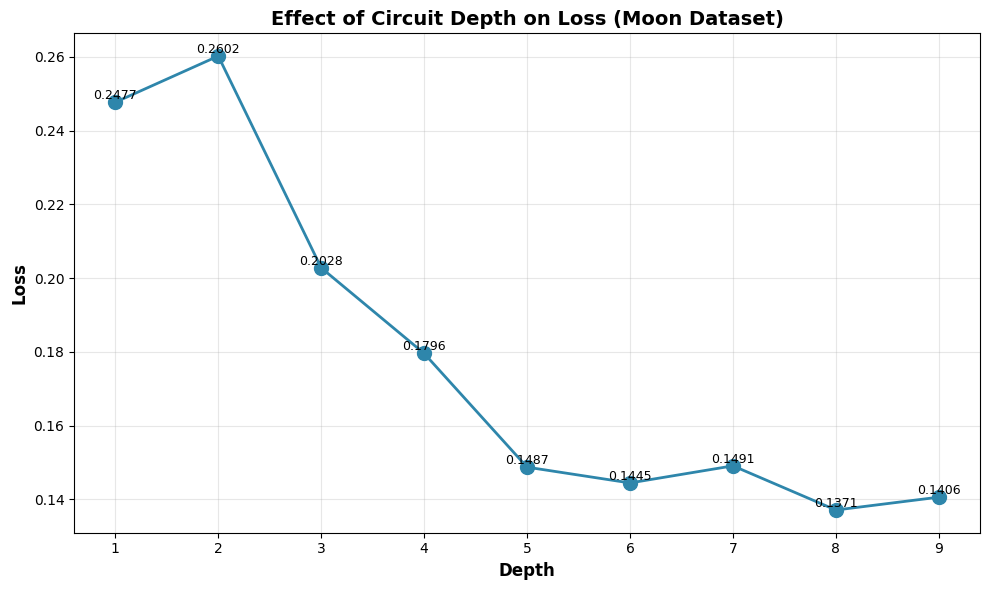

Loss Summary:
Depth 1: 0.247700
Depth 2: 0.260231
Depth 3: 0.202788
Depth 4: 0.179573
Depth 5: 0.148732
Depth 6: 0.144451
Depth 7: 0.149088
Depth 8: 0.137107
Depth 9: 0.140596


In [20]:
# Visualize Loss vs Depth
import matplotlib.pyplot as plt
import numpy as np

depths_list = sorted(accuracy_results.keys())
losses = [accuracy_results[d]['loss'] for d in depths_list]

plt.figure(figsize=(10, 6))
plt.plot(depths_list, losses, 'o-', linewidth=2, markersize=10, color='#2E86AB')
plt.xlabel('Depth', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Effect of Circuit Depth on Loss (Moon Dataset)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(depths_list)

# Add value labels on each point
for d, loss in zip(depths_list, losses):
    plt.text(d, loss, f'{loss:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("Loss Summary:")
for d in depths_list:
    print(f"Depth {d}: {accuracy_results[d]['loss']:.6f}")

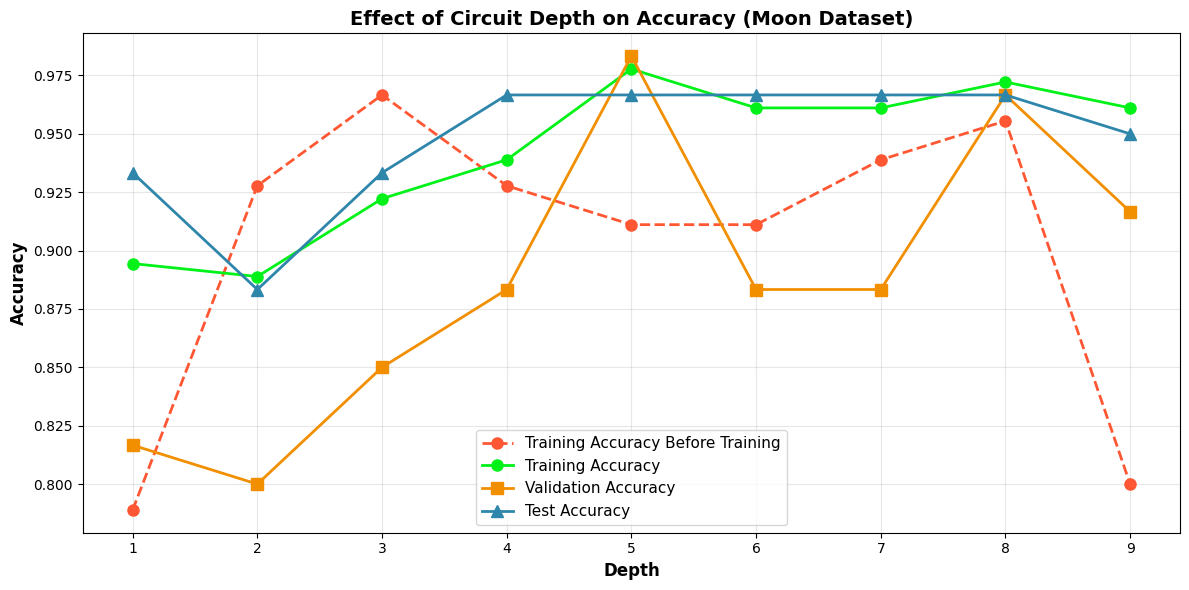


Accuracy Summary:
Depth    Train Acc Before Train Acc After
--------------------------------------------------
1        0.7889     0.8944      
2        0.9278     0.8889      
3        0.9667     0.9222      
4        0.9278     0.9389      
5        0.9111     0.9778      
6        0.9111     0.9611      
7        0.9389     0.9611      
8        0.9556     0.9722      
9        0.8000     0.9611      


In [21]:
# Visualize Accuracy vs Depth
depths_list = sorted(accuracy_results.keys())
train_accs_before = [accuracy_results[d]['train_acc_before'] for d in depths_list]
train_accs_after = [accuracy_results[d]['train_acc_after'] for d in depths_list]
val_accs = [accuracy_results[d]['val_acc'] for d in depths_list]
test_accs = [accuracy_results[d]['test_acc'] for d in depths_list]

plt.figure(figsize=(12, 6))

plt.plot(depths_list, train_accs_before, 'o--', linewidth=2, markersize=8, label='Training Accuracy Before Training', color="#FF5733")
plt.plot(depths_list, train_accs_after, 'o-', linewidth=2, markersize=8, label='Training Accuracy', color="#01F119")
plt.plot(depths_list, val_accs, 's-', linewidth=2, markersize=8, label='Validation Accuracy', color='#F18F01')
plt.plot(depths_list, test_accs, '^-', linewidth=2, markersize=8, label='Test Accuracy', color='#2E86AB')

plt.xlabel('Depth', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Effect of Circuit Depth on Accuracy (Moon Dataset)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(depths_list)
# plt.ylim([0.8, 1.02])

plt.tight_layout()
plt.show()

print("\nAccuracy Summary:")
print(f"{'Depth':<8} {'Train Acc Before':<10} {'Train Acc After':<12}")
print("-" * 50)
for d in depths_list:
    print(f"{d:<8} {train_accs_before[depths_list.index(d)]:<10.4f} {train_accs_after[depths_list.index(d)]:<12.4f}")

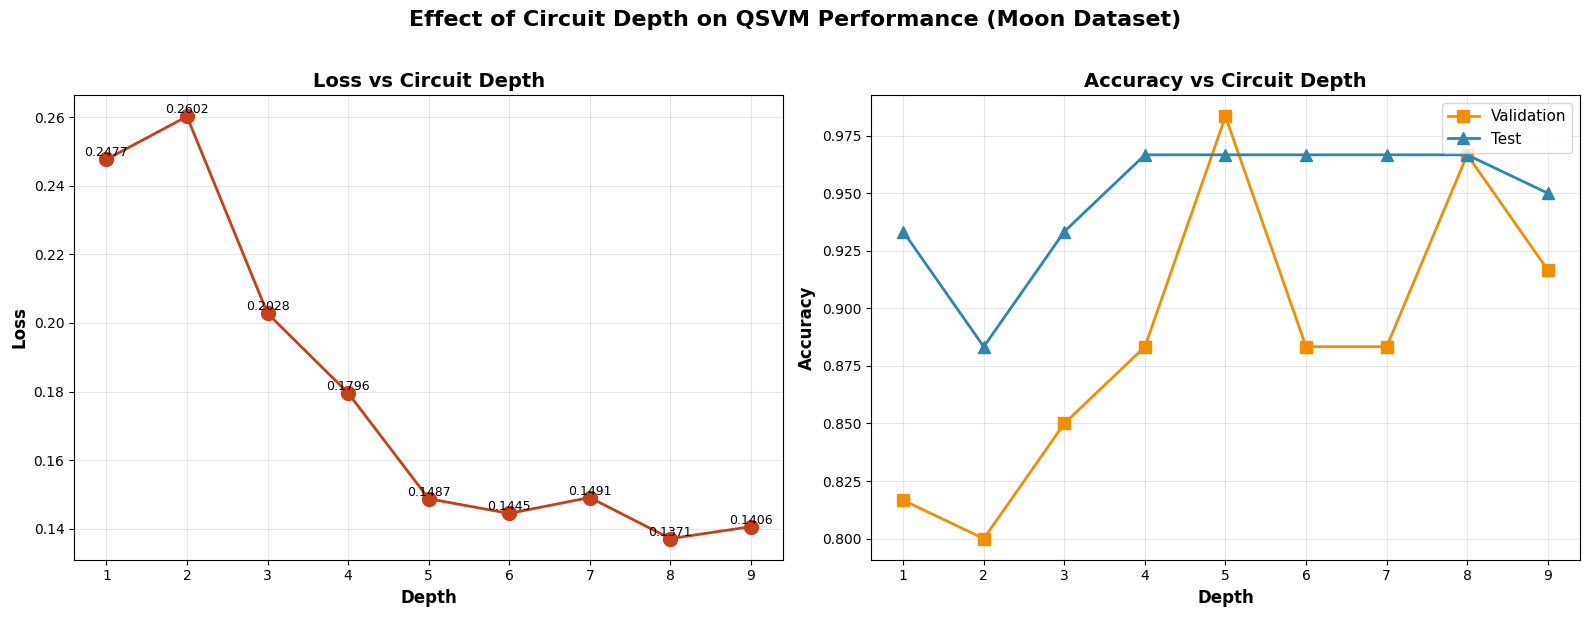

In [22]:
# Combined visualization: Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Loss vs Depth
ax1.plot(depths_list, losses, 'o-', linewidth=2, markersize=10, color='#C73E1D')
ax1.set_xlabel('Depth', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Loss vs Circuit Depth', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(depths_list)

for d, loss in zip(depths_list, losses):
    ax1.text(d, loss, f'{loss:.4f}', ha='center', va='bottom', fontsize=9)

# Right plot: Accuracy vs Depth
# plt.plot(depths_list, train_accs_before, 'o--', linewidth=2, markersize=8, label='Traini Before', color="#FF5733")
# ax2.plot(depths_list, train_accs_after, 'o-', linewidth=2, markersize=8, label='Train After', color='#01F119')
ax2.plot(depths_list, val_accs, 's-', linewidth=2, markersize=8, label='Validation', color='#F18F01')
ax2.plot(depths_list, test_accs, '^-', linewidth=2, markersize=8, label='Test', color='#2E86AB')
ax2.set_xlabel('Depth', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy vs Circuit Depth', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(depths_list)

plt.suptitle('Effect of Circuit Depth on QSVM Performance (Moon Dataset)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

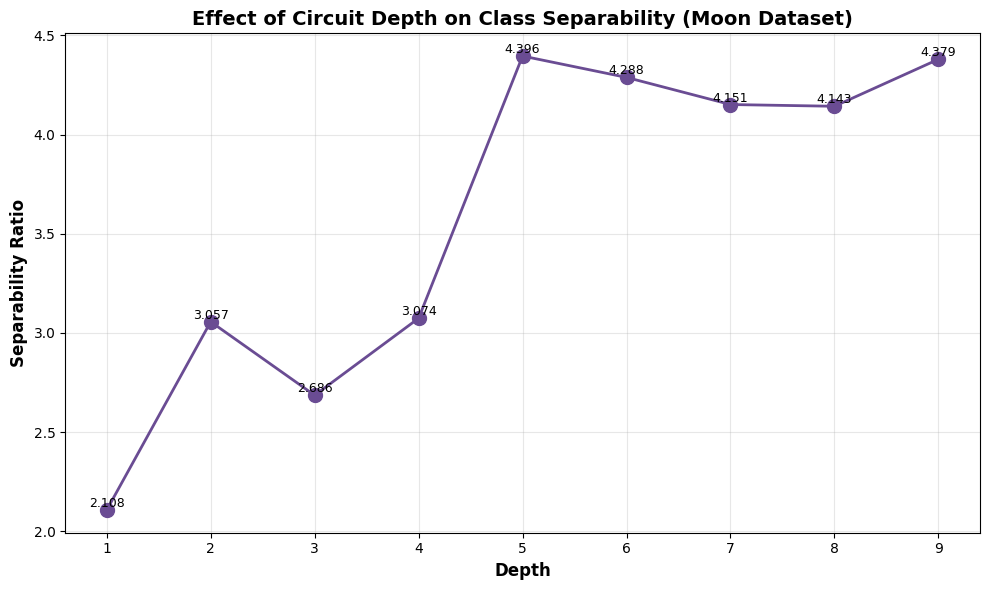


Separability Summary:
Depth 1: 2.107790
Depth 2: 3.056662
Depth 3: 2.686168
Depth 4: 3.074225
Depth 5: 4.395723
Depth 6: 4.287981
Depth 7: 4.151299
Depth 8: 4.142555
Depth 9: 4.379350


In [23]:
# Visualize Separability Ratio vs Depth
sep_ratios = [accuracy_results[d]['sep_ratio'] for d in depths_list]

plt.figure(figsize=(10, 6))
plt.plot(depths_list, sep_ratios, 'o-', linewidth=2, markersize=10, color='#6A4C93')
plt.xlabel('Depth', fontsize=12, fontweight='bold')
plt.ylabel('Separability Ratio', fontsize=12, fontweight='bold')
plt.title('Effect of Circuit Depth on Class Separability (Moon Dataset)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(depths_list)

# Add value labels on each point
for d, sep in zip(depths_list, sep_ratios):
    plt.text(d, sep, f'{sep:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nSeparability Summary:")
for d in depths_list:
    print(f"Depth {d}: {accuracy_results[d]['sep_ratio']:.6f}")

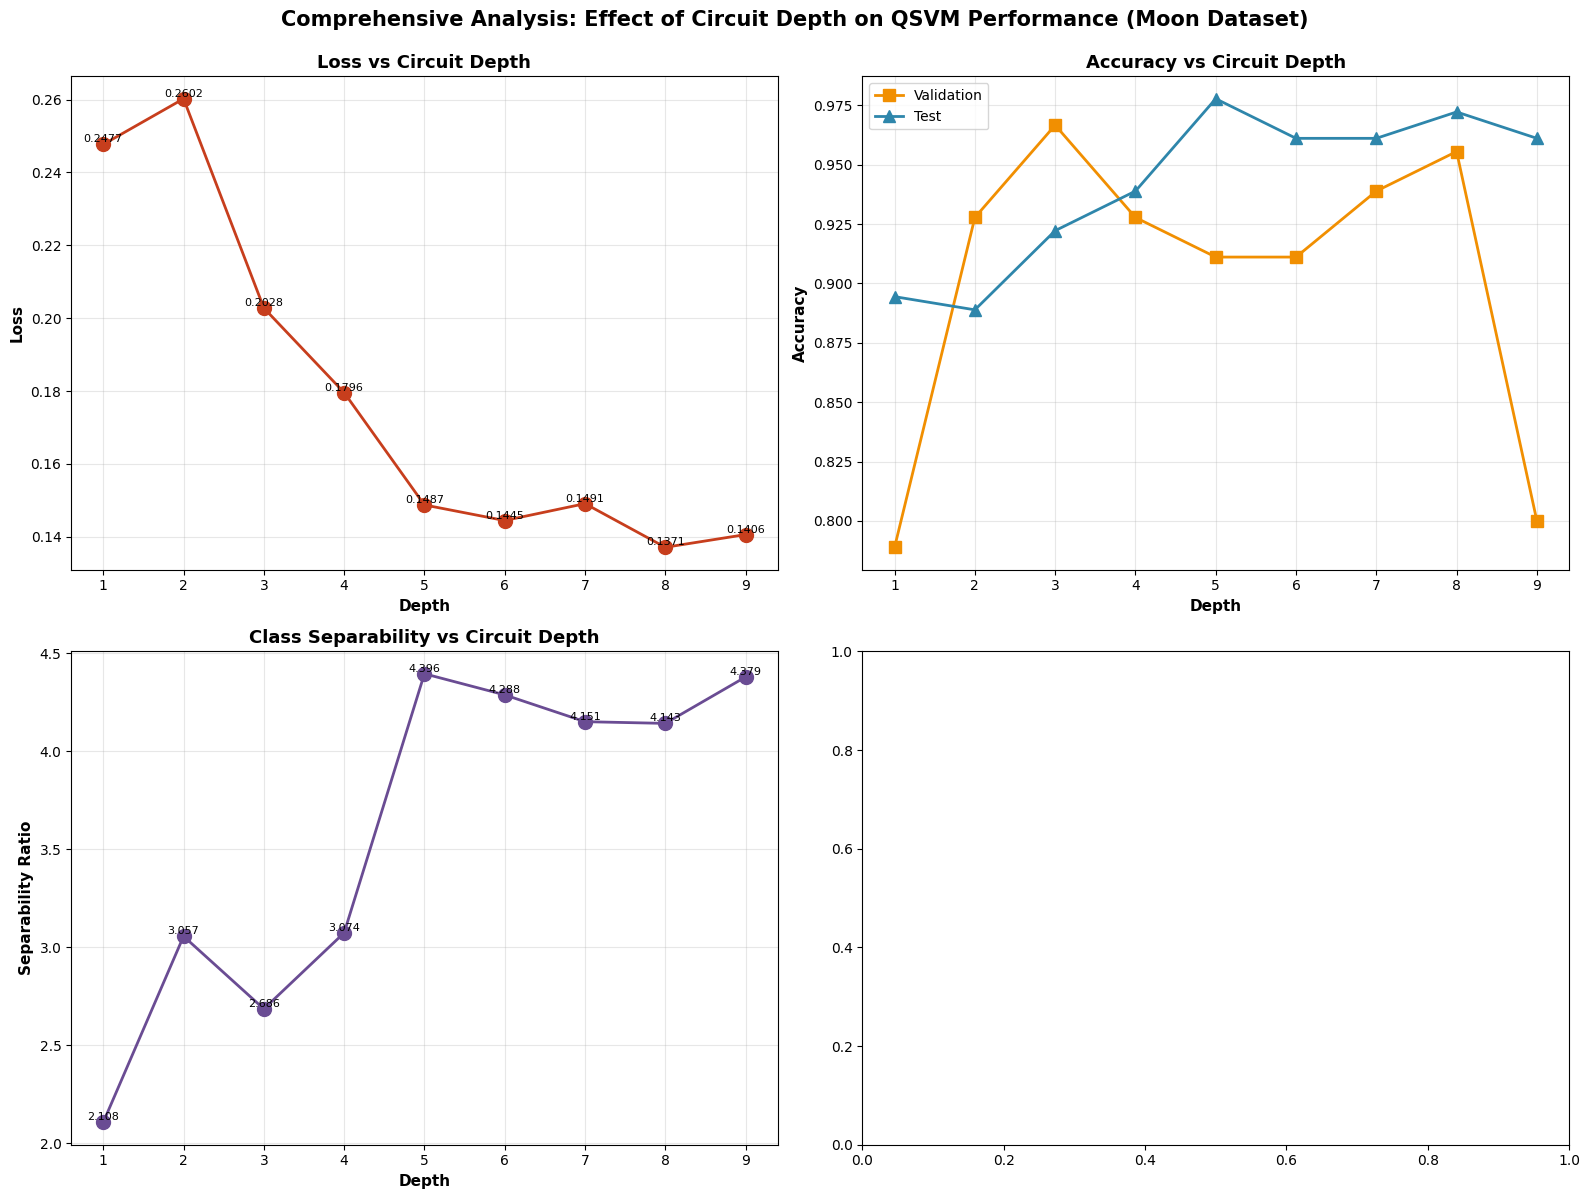

In [24]:
# Comprehensive visualization: Loss, Accuracy, and Separability
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Loss vs Depth
ax1.plot(depths_list, losses, 'o-', linewidth=2, markersize=10, color='#C73E1D')
ax1.set_xlabel('Depth', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax1.set_title('Loss vs Circuit Depth', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(depths_list)
for d, loss in zip(depths_list, losses):
    ax1.text(d, loss, f'{loss:.4f}', ha='center', va='bottom', fontsize=8)

# Plot 2: Accuracy vs Depth
ax2.plot(depths_list, train_accs_before, 's-', linewidth=2, markersize=8, label='Validation', color='#F18F01')
ax2.plot(depths_list, train_accs_after, '^-', linewidth=2, markersize=8, label='Test', color='#2E86AB')
ax2.set_xlabel('Depth', fontsize=11, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Accuracy vs Circuit Depth', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(depths_list)


# Plot 3: Separability Ratio vs Depth
ax3.plot(depths_list, sep_ratios, 'o-', linewidth=2, markersize=10, color='#6A4C93')
ax3.set_xlabel('Depth', fontsize=11, fontweight='bold')
ax3.set_ylabel('Separability Ratio', fontsize=11, fontweight='bold')
ax3.set_title('Class Separability vs Circuit Depth', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(depths_list)
for d, sep in zip(depths_list, sep_ratios):
    ax3.text(d, sep, f'{sep:.3f}', ha='center', va='bottom', fontsize=8)



plt.suptitle('Comprehensive Analysis: Effect of Circuit Depth on QSVM Performance (Moon Dataset)', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [25]:
# Statistical Summary Table
import pandas as pd

summary_data = []
for d in depths_list:
    summary_data.append({
        'Depth': d,
        'Final Loss': accuracy_results[d]['loss'],
        # 'Val Acc': accuracy_results[d]['val_acc'],
        # 'Test Acc': accuracy_results[d]['test_acc'],
        'Sep Ratio': accuracy_results[d]['sep_ratio'],
    })

df_summary = pd.DataFrame(summary_data)
print("=" * 120)
print("DEPTH ANALYSIS SUMMARY - MGQ DATASET (Best Model per Depth)")
print("=" * 120)
print(df_summary.to_string(index=False))
print("=" * 120)

# Find optimal depth
best_depth_by_loss = min(depths_list, key=lambda d: accuracy_results[d]['loss'])
best_depth_by_acc = max(depths_list, key=lambda d: accuracy_results[d]['train_acc_after'])
best_depth_by_sep = max(depths_list, key=lambda d: accuracy_results[d]['sep_ratio'])

print(f"\n Best Depth by Loss: {best_depth_by_loss} (Loss = {accuracy_results[best_depth_by_loss]['loss']:.6f})")
print(f" Best Depth by Test Accuracy: {best_depth_by_acc} (Accuracy = {accuracy_results[best_depth_by_acc]['train_acc_after']:.4f})")
print(f" Best Depth by Separability: {best_depth_by_sep} (Sep Ratio = {accuracy_results[best_depth_by_sep]['sep_ratio']:.4f})")



DEPTH ANALYSIS SUMMARY - MGQ DATASET (Best Model per Depth)
 Depth  Final Loss  Sep Ratio
     1    0.247700   2.107790
     2    0.260231   3.056662
     3    0.202788   2.686168
     4    0.179573   3.074225
     5    0.148732   4.395723
     6    0.144451   4.287981
     7    0.149088   4.151299
     8    0.137107   4.142555
     9    0.140596   4.379350

 Best Depth by Loss: 8 (Loss = 0.137107)
 Best Depth by Test Accuracy: 5 (Accuracy = 0.9778)
 Best Depth by Separability: 5 (Sep Ratio = 4.3957)


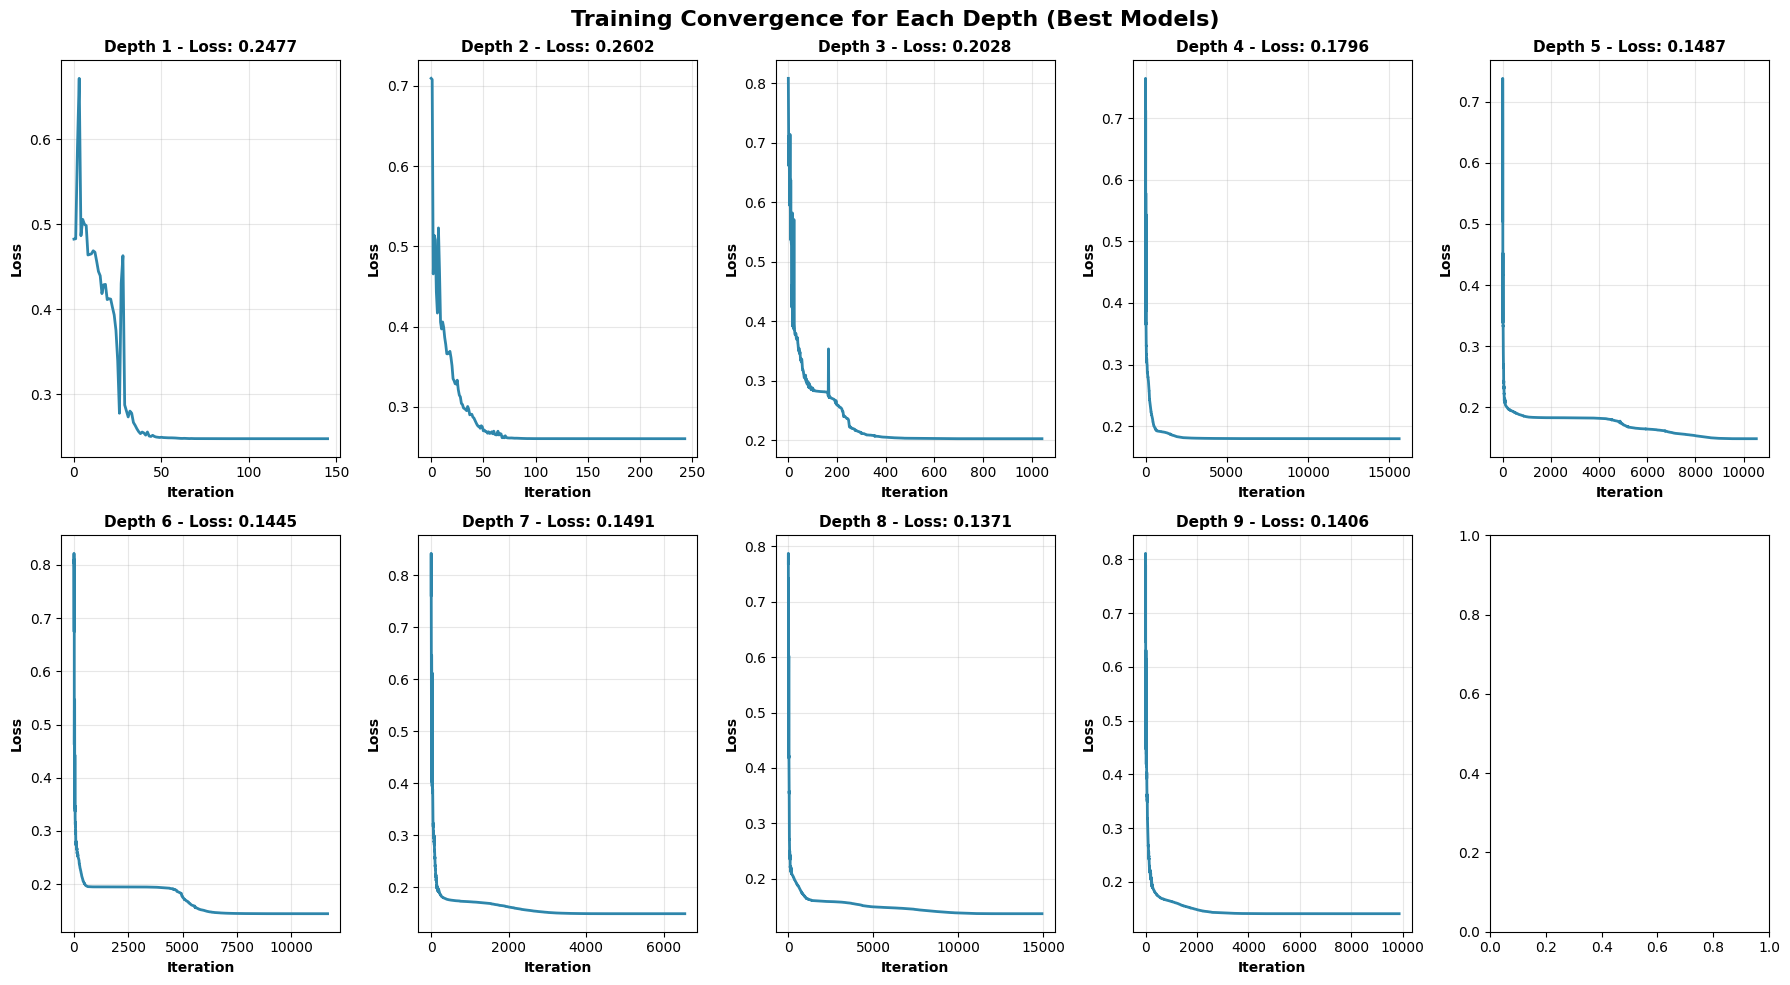

In [26]:
# Visualize training convergence for best models
fig, axes = plt.subplots(2, 5, figsize=(18, 10))
axes = axes.flatten()

for idx, depth in enumerate(depths_list):
    model_info = best_models[depth]
    tqfm = model_info['tqfm']
    loss_history = tqfm.loss_history
    
    axes[idx].plot(loss_history, linewidth=2, color='#2E86AB')
    axes[idx].set_xlabel('Iteration', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Loss', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'Depth {depth} - Loss: {loss_history[-1]:.4f}', 
                       fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
# Hide the 6th subplot if only 5 depths
if len(depths_list) == 5:
    axes[5].axis('off')

plt.suptitle('Training Convergence for Each Depth (Best Models)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

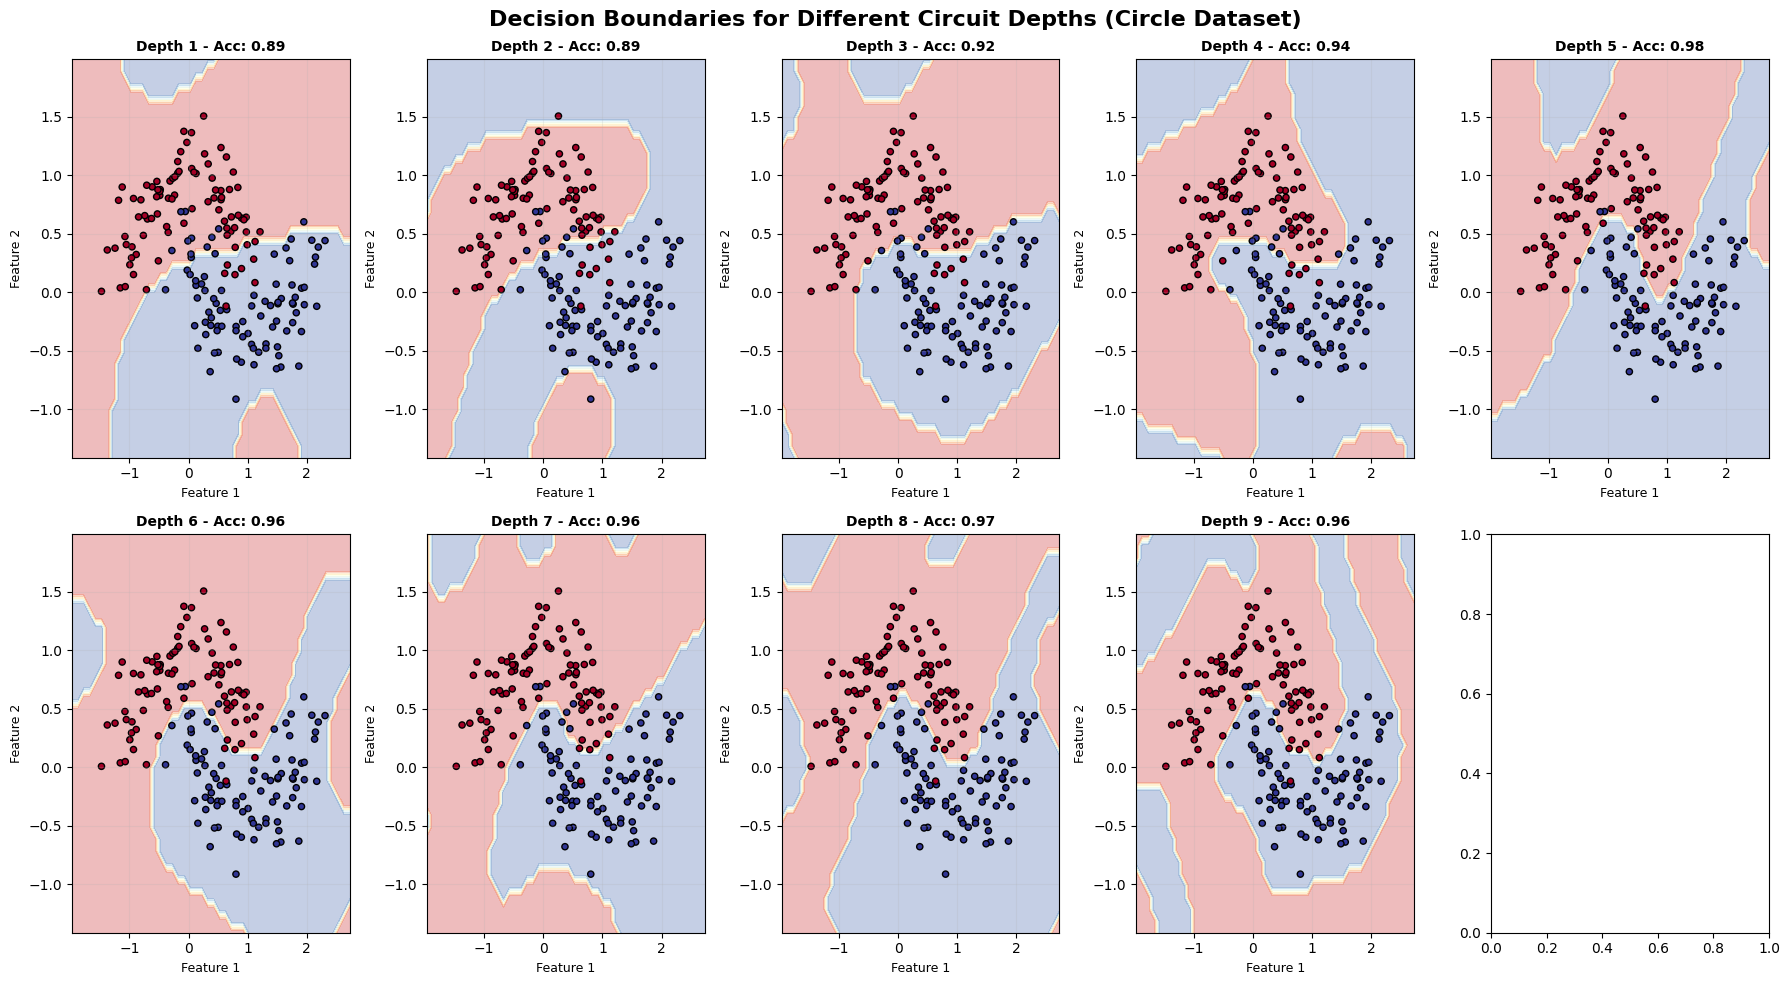

In [27]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from src.kernel_estimate import KernelMatrix

fig, axes = plt.subplots(2, 5, figsize=(18, 10))
axes = axes.flatten()

h = 0.1  # step size in the mesh
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# For precomputed kernel, we need to compute kernel between mesh points and training data
mesh_points = np.c_[xx.ravel(), yy.ravel()]

# The model is already trained with precomputed kernel
for idx, depth in enumerate(depths_list):
	svm = accuracy_results[depth]['svm_after']
	tqfm = best_models[depth]['tqfm']

	# Create mesh grid for decision boundary
	K_mesh = KernelMatrix.compute_kernel_matrix_with_inner_products(mesh_points, X_train, tqfm.optimal_params, tqfm.circuit)

	# Predict on mesh grid using the precomputed kernel
	Z = svm.predict(K_mesh)
	Z = Z.reshape(xx.shape)

	# Plot decision boundary
	axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
	axes[idx].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='RdYlBu', edgecolors='k', s=20)
	axes[idx].set_title(f'Depth {depth} - Acc: {accuracy_results[depth]["train_acc_after"]:.2f}', fontsize=10, fontweight='bold')
	axes[idx].set_xlabel('Feature 1', fontsize=9)
	axes[idx].set_ylabel('Feature 2', fontsize=9)
	axes[idx].grid(True, alpha=0.2)

plt.suptitle('Decision Boundaries for Different Circuit Depths (Circle Dataset)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()